In [1]:
import pandas as pd
import nibabel as nib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('..')
import sfp
import pyPyrTools as ppt
import math
from scipy import stats
from scipy import optimize as opt

/home/billbrod/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/billbrod/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [54]:
df[(df.varea==1)&(df.R2>55)].drop_duplicates('voxel').sort_values('R2', ascending=False).head(5)[['voxel', 'R2', 'varea', 'hemi', 'angle' ,'eccen']]

,voxel,R2,varea,hemi,angle,eccen
9643,2962,65.773674,1,lh,138.635147,8.170883
6171,494,65.208328,1,lh,177.215652,5.022409
9541,2963,65.189392,1,lh,134.837509,8.108796
5760,485,65.087975,1,lh,178.492249,4.639922
9432,2781,64.600609,1,lh,140.614029,8.023201


In [106]:
# Pick a V1 voxel with a good R2
voxel_df = df[(df.voxel==8014)]
voxel_df.head(1)[['voxel', 'varea', 'R2', 'eccen', 'angle', 'hemi']]

,voxel,varea,R2,eccen,angle,hemi
1651,8014,1,57.73922,1.870936,108.3013,rh


In [135]:
voxel_eccen = voxel_df.eccen.unique()[0]
voxel_angle = math.radians(voxel_df.angle.unique()[0])
angle = ppt.mkAngle(1080)
R = ppt.mkR(1080) * (24 / 1080.)
angle_dist = abs(angle - voxel_angle)
angle_dist /= angle_dist.max()
eccen_dist = abs(R - voxel_eccen)
eccen_dist /= eccen_dist.max()
flattened_idx = (angle_dist+eccen_dist).argmin()
twod_resp = []
for i, row in voxel_df.iterrows():
    dx, dy, _, _ = sfp.stimuli.create_sf_maps_cpp(1080, w_r=row.w_r, w_a=row.w_a)
    dx /= (24 / 1080.)
    dy /= (24 / 1080.)
    twod_resp.append((dx.flatten()[flattened_idx], dy.flatten()[flattened_idx], row.amplitude_estimate_median))
twod_resp = np.array(twod_resp)

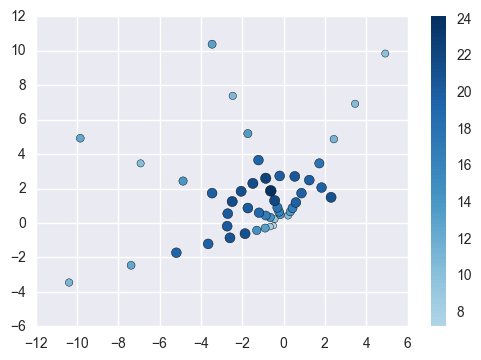

In [138]:
s = twod_resp[:, 2].copy()
s -= s.min()
s /= s.max()
plt.scatter(twod_resp[:,0], twod_resp[:,1], s=40*(s+.5), c=twod_resp[:,2],cmap='RdBu', norm=sfp.plotting.MidpointNormalize(midpoint=0)) 
plt.colorbar()
scatter_ax = plt.gca()

In [86]:
def twoD_Gaussian((x, y), amplitude, mu_x, mu_y, sig_xx, sig_xy, sig_yx, sig_yy):
    twod_gauss = stats.multivariate_normal(mean=(mu_x, mu_y), cov=[[sig_xx, sig_xy],[sig_yx, sig_yy]])
    xgrid, ygrid = np.meshgrid(x, y)
    X = np.empty(xgrid.shape + (2,))
    X[:,:,0] = xgrid
    X[:,:,1] = ygrid
    gauss_resp = twod_gauss.pdf(X)
    gauss_resp /= gauss_resp.max()
    return amplitude * gauss_resp
def fit_twoD_Gaussian(*args, **kwargs):
    return np.diagonal(twoD_Gaussian(*args, **kwargs))

In [87]:
x= twod_resp[:,0]
y=twod_resp[:,1]
popt, pcov = opt.curve_fit(fit_twoD_Gaussian, (x, y), twod_resp[:,2], p0=(20, 0, 0, 1, 0, 0, 1))

In [88]:
popt

array([19.99936831, -2.63136983,  2.33924012, 64.07908757,  0.        ,
       24.31571838, 38.9081664 ])

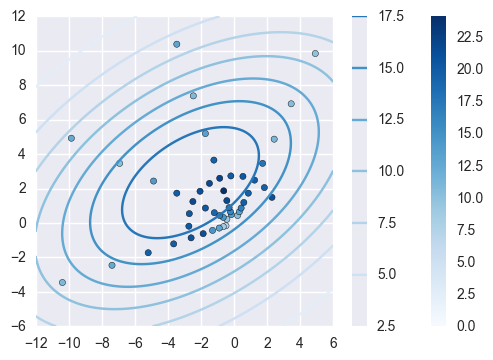

In [89]:
x = np.linspace(-12, 6, 1000)
y = np.linspace(-6, 12, 1000)
plt.scatter(twod_resp[:,0], twod_resp[:,1], c=twod_resp[:,2],cmap='Blues', vmin=0, vmax=twod_resp[:,2].max())
plt.colorbar()
plt.contour(x, y, twoD_Gaussian((x, y), *popt), aspect='equal', cmap='Blues', vmin=0, vmax=twod_resp[:,2].max())# levels=[0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 19.9])
plt.colorbar()
ax = plt.gca()
ax.set_xlim(scatter_ax.get_xlim())
ax.set_ylim(scatter_ax.get_ylim())
plt.savefig('model.pdf')

In [109]:
resp_df = pd.DataFrame(twod_resp, columns=['w_x', 'w_y', 'response'])
resp_df['distance'] = np.sqrt(resp_df.w_x**2 + resp_df.w_y**2)
resp_df['angle'] = np.arctan2(resp_df.w_y, resp_df.w_x)

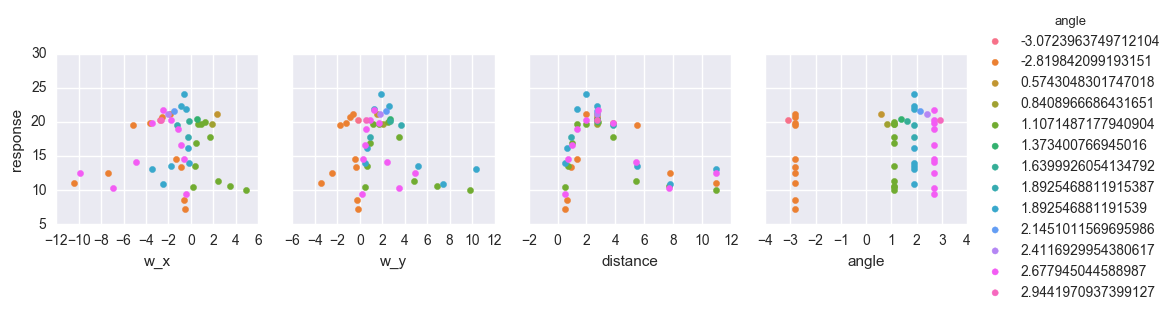

In [112]:
g = sns.PairGrid(resp_df, x_vars=['w_x', 'w_y', 'distance', 'angle'], y_vars=['response'], hue='angle')
g.map(plt.scatter)
g.add_legend()

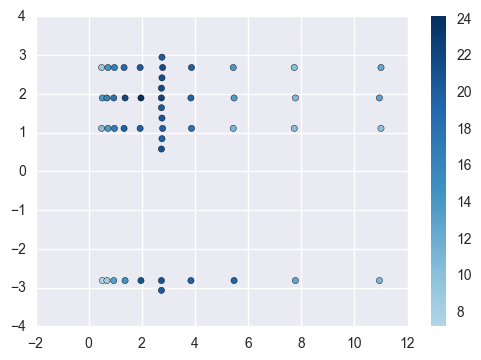

In [113]:
plt.scatter(resp_df['distance'], resp_df['angle'], c=resp_df['response'],cmap='RdBu', norm=sfp.plotting.MidpointNormalize(midpoint=0)) 
plt.colorbar()
scatter_ax = plt.gca()

In [115]:
x= resp_df['distance'].values
y= resp_df['angle'].values
popt, pcov = opt.curve_fit(fit_twoD_Gaussian, (x, y), resp_df['response'].values, p0=(20, 0, 0, 1, 0, 0, 1))

In [116]:
popt

array([ 1.94726048e+01,  2.54296460e+00,  5.19725555e+00,  1.64260538e+03,
        0.00000000e+00, -5.46448128e+03,  1.84462144e+04])

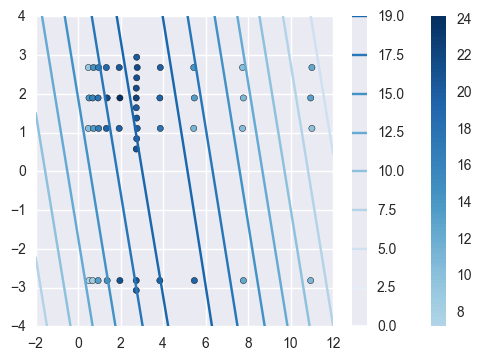

In [121]:
x = np.linspace(-2, 12, 1000)
y = np.linspace(-2*np.pi, 2*np.pi, 1000)
plt.scatter(resp_df['distance'], resp_df['angle'], c=resp_df['response'],cmap='RdBu', norm=sfp.plotting.MidpointNormalize(midpoint=0)) 
plt.colorbar()
plt.contour(x, y, twoD_Gaussian((x, y), *popt), aspect='equal', cmap='Blues', vmin=0, vmax=twod_resp[:,2].max(), levels=[0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 19])
plt.colorbar()
ax = plt.gca()
ax.set_xlim(scatter_ax.get_xlim())
ax.set_ylim(scatter_ax.get_ylim())
plt.savefig('model.pdf')